# SPAM HAM DETECTION

***

In [24]:
### importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# Checking how CountVectorizer works

In [25]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'Please call me... PLEASE!']

In [26]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

# examine the fitted vocabulary
vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

In [27]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)

In [28]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]], dtype=int64)

In [29]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


> **Vectorization** is basically the process of turning a collection of text documents into numerical feature vectors.
> This specific strategy (tokenization --> counting --> normalization) is called the **Bag of Words** or "Bag of n-grams" representation.
> Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

# Data Reading

In [30]:
# read file into pandas using a relative path
sms = pd.read_csv("dataset\spam.csv", 
                  encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']

sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis (EDA)

## Checking some basic things ...

In [31]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [32]:
# not all messages are unique. out of interest, lets see what's the duplicate message
repeat_msg = []
for msg, count in sms['message'].value_counts().to_dict().items():
    if count >1:
        repeat_msg.append(msg)

print("Repeated messaged :")
counter = 1
for j in repeat_msg:
    print(str(counter),':', j)
    counter+=1

Repeated messaged :
1 : Sorry, I'll call later
2 : I cant pick the phone right now. Pls send a message
3 : Ok...
4 : 7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\"... good morning dear"
5 : Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...
6 : Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..
7 : Ok.
8 : Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.
9 : Okie
10 : Ok
11 : Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!
12 : Hi! You just spoke to MANEESHA V. We'd like to know

## Let's see imbalance between the two classes ...

In [33]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

We have `4825` ham message and `747` spam message

Text(0.5, 1.0, 'Count of Spam and Ham')

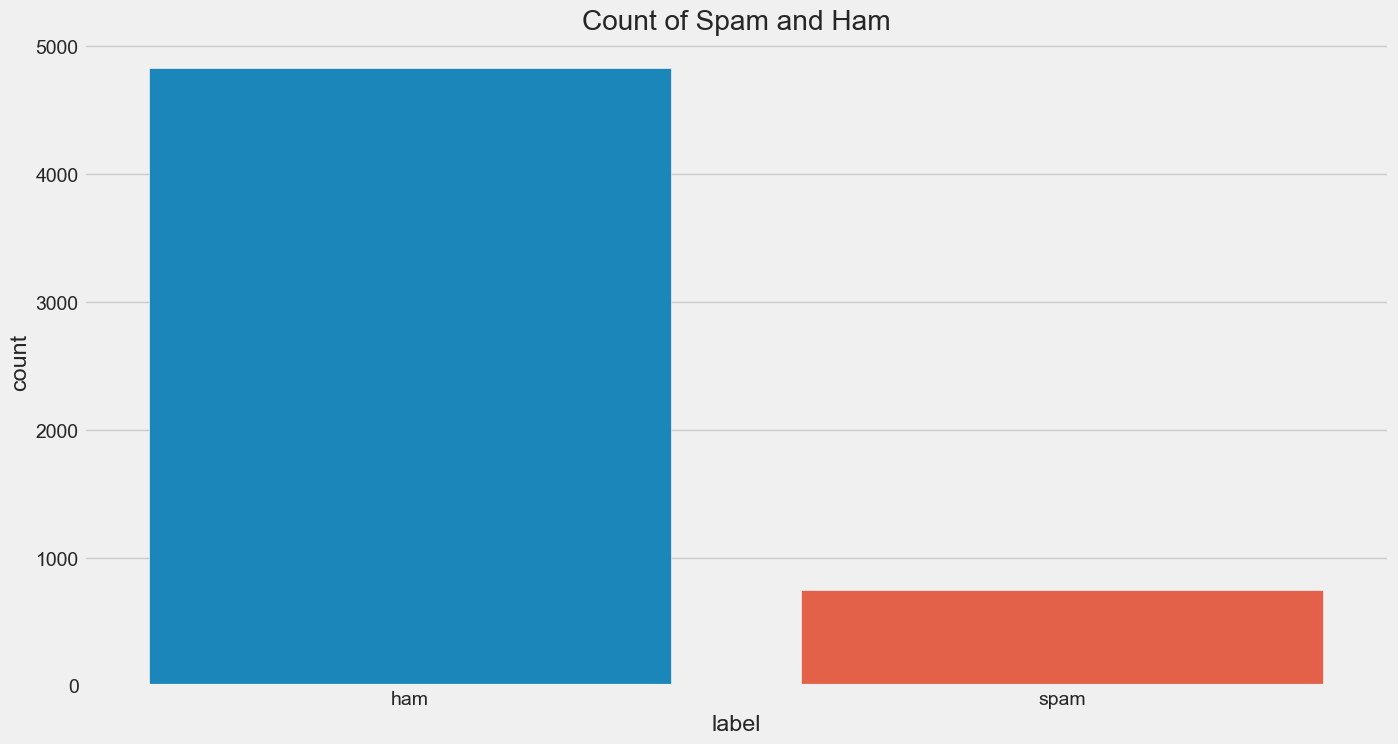

In [34]:
# lets see label distribution
plt.figure(figsize=(15,8))
sns.countplot(x='label', data=sms)
plt.title("Count of Spam and Ham")

## Checking on distribution of message length between spam and ham ...

In [35]:
# convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [36]:
### creating a feature - length of message
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

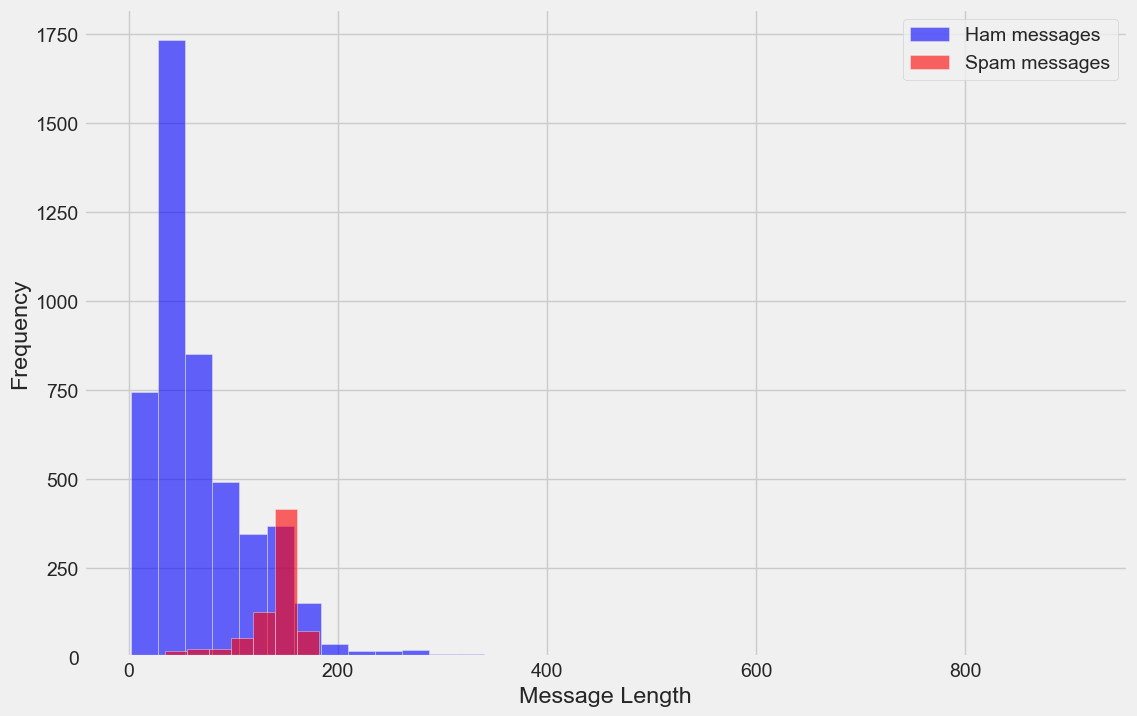

In [37]:
### plotting distribution of message length for spam and hams
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

> Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

In [38]:
sms[sms.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


In [39]:
sms[sms.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


## Checking on common words (top 20) in spam and ham messaged ...

In [40]:
### lets also check on common words in spam and ham messages
from collections import Counter
import string
from nltk.corpus import stopwords

def clean_text(text):
    words = text.lower().translate(str.maketrans('', '', string.punctuation)).split()
    return [word for word in words if word not in stopwords.words('english')]

result_dict={'spam':{}, 'ham':{}}
for label in ['spam', 'ham']:
    result_dict[label]['all_words'] = sms[sms['label'] == label]['message'].apply(clean_text).sum()
    result_dict[label]['spam_word_freq'] = Counter(result_dict[label]['all_words'])

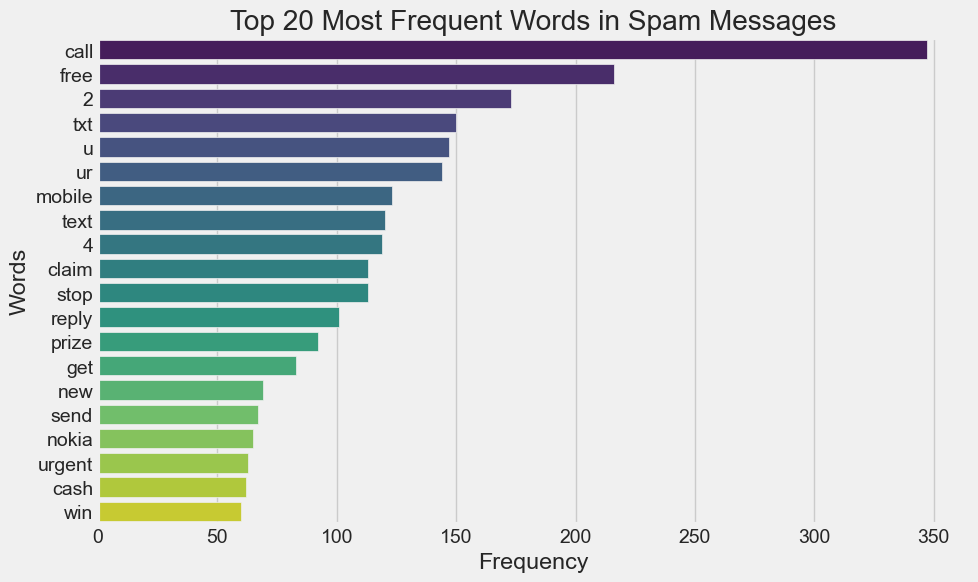

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select top N words
top_n = 20
top_words = result_dict['spam']['spam_word_freq'].most_common(top_n)

# Prepare data
words, freqs = zip(*top_words)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=np.array(freqs), y=np.array(words), palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title(f'Top {top_n} Most Frequent Words in Spam Messages')
plt.show()

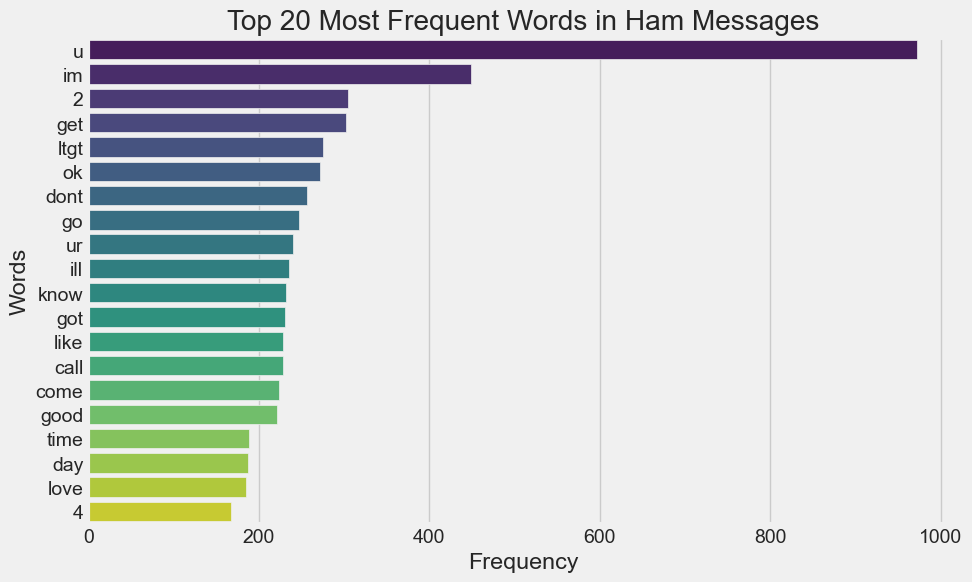

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select top N words
top_n = 20
top_words = result_dict['ham']['spam_word_freq'].most_common(top_n)

# Prepare data
words, freqs = zip(*top_words)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=np.array(freqs), y=np.array(words), palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title(f'Top {top_n} Most Frequent Words in Ham Messages')
plt.show()

## How about word cloud for spam and ham messages ...

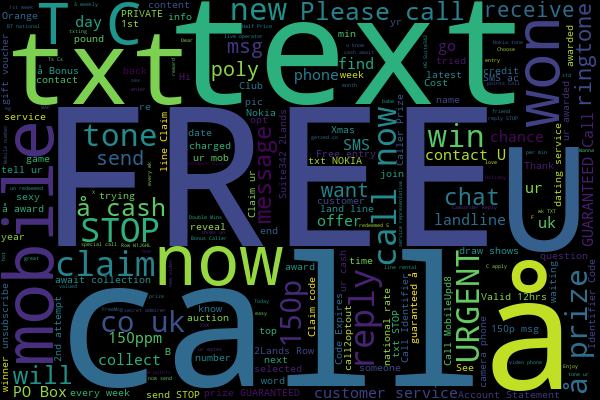

In [43]:
from wordcloud import WordCloud
spam_words = ' '.join(sms[sms['label']=='spam']['message'])
ham_words = ' '.join(sms[sms['label']=='ham']['message'])

WordCloud(width=600, height=400).generate(spam_words).to_image()

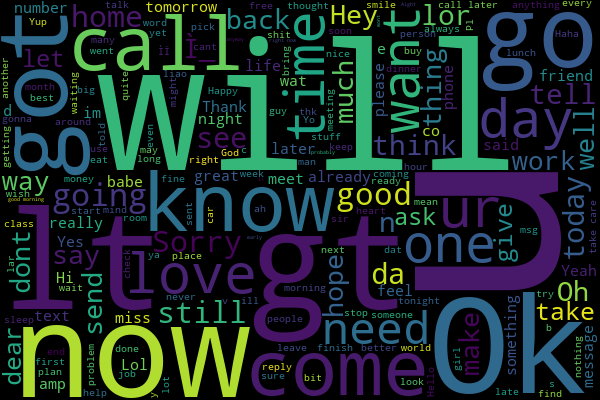

In [44]:
WordCloud(width=600, height=400).generate(ham_words).to_image()

## Let's do some N-gram analysis now on spam messages ...

In [45]:
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(sms[sms['label']=='spam']['message'])

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

'''
1. lets do bigrams and remove any stop words.
2. fit and transform the vectorizer
3. get total count of each n-gram across all spam messages
4. extracting n-grams and their frequencies
5. sorting by frequency
'''
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(sms[sms['label']=='spam']['message'])
sum_words = X.sum(axis=0)
word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)


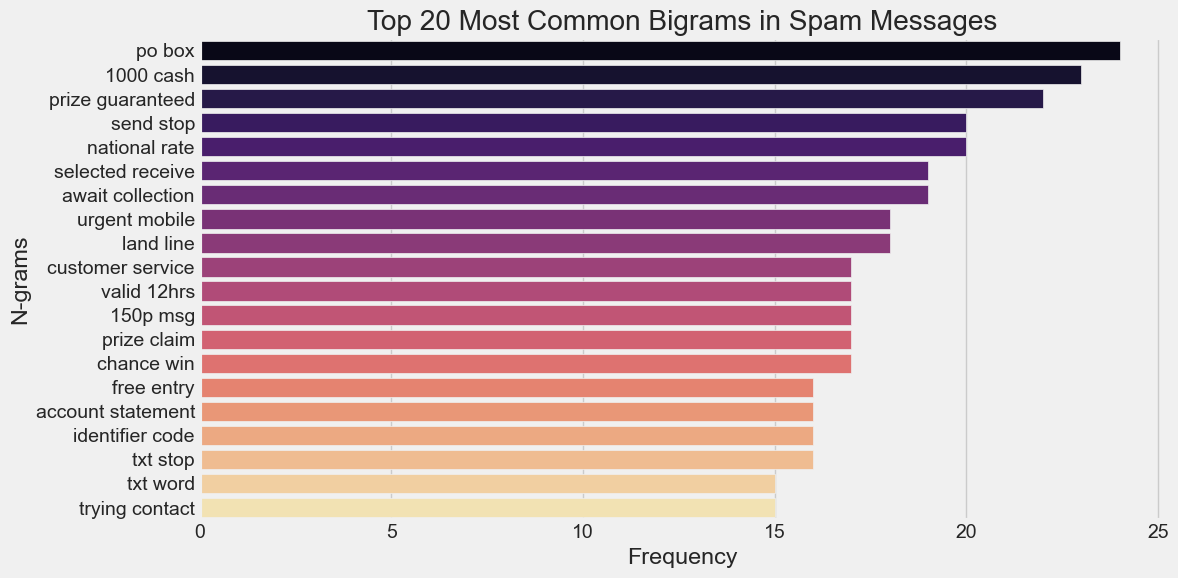

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set number of top n-grams to display
top_n = 20
top_ngrams = word_freq[:top_n]

# Unzip the n-grams and their frequencies
ngrams, freqs = zip(*top_ngrams)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=np.array(freqs), y=np.array(ngrams), palette='magma')
plt.xlabel("Frequency")
plt.ylabel("N-grams")
plt.title(f"Top {top_n} Most Common Bigrams in Spam Messages")
plt.tight_layout()
plt.show()

# Text Pre-processing

> The classification algorithms that we usally use need some sort of numerical feature vector in order to perform the classification task.

> Let's try `bag-of-words` approach, where each unique word in a text will be represented by one number.

> In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

In [48]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

> Now let's "tokenize" these messages. Tokenization is a term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [49]:
sms['clean_msg'] = sms.message.apply(text_process)
sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [50]:
words = sms[sms.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


## Vectorization

> Currently, we have the messages as lists of tokens and now we need to convert each of those messages into a vector that machine learning models can understand.


> We'll do that in three steps using the bag-of-words model:

> 1. Count how many times does a word occur in each message (Known as term frequency)
> 2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
> 3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [51]:
sms[['label_num', 'clean_msg']].head(5)

,label_num,clean_msg
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif oni
2,1,Free entry wkly comp win FA Cup final tkts 21s...
3,0,dun say early hor c already say
4,0,Nah think goes usf lives around though


In [52]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split

# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5572,)
(5572,)
(4179,)
(1393,)
(4179,)
(1393,)


In [53]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)


# combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
print(type(X_train_dtm), X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
print(type(X_test_dtm), X_test_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (4179, 7996)
<class 'scipy.sparse._csr.csr_matrix'> (1393, 7996)


In [54]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x7996 sparse matrix of type '<class 'numpy.float64'>'
	with 34796 stored elements in Compressed Sparse Row format>

# Building and evaluating a model

> We will use multinomial Naive Bayes.

In [55]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [56]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: total: 15.6 ms
Wall time: 5.75 ms


MultinomialNB()

## Evaluation

In [57]:
from sklearn import metrics

# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_class)

=======Accuracy Score===========
0.9827709978463748
=======Confision Matrix===========


array([[1205,    8],
       [  16,  164]], dtype=int64)

In [58]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1213
           1       0.95      0.91      0.93       180

    accuracy                           0.98      1393
   macro avg       0.97      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



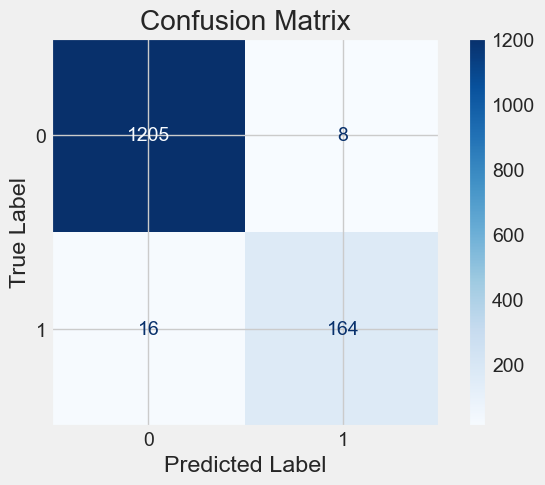

In [59]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [0,1]
cm = confusion_matrix(y_test, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [60]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([2.11903975e-02, 3.97831612e-04, 1.06470895e-03, ...,
       1.31939653e-02, 9.99821127e-05, 6.04083365e-06])

In [61]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9774342768159751

## ROC-AUC curve

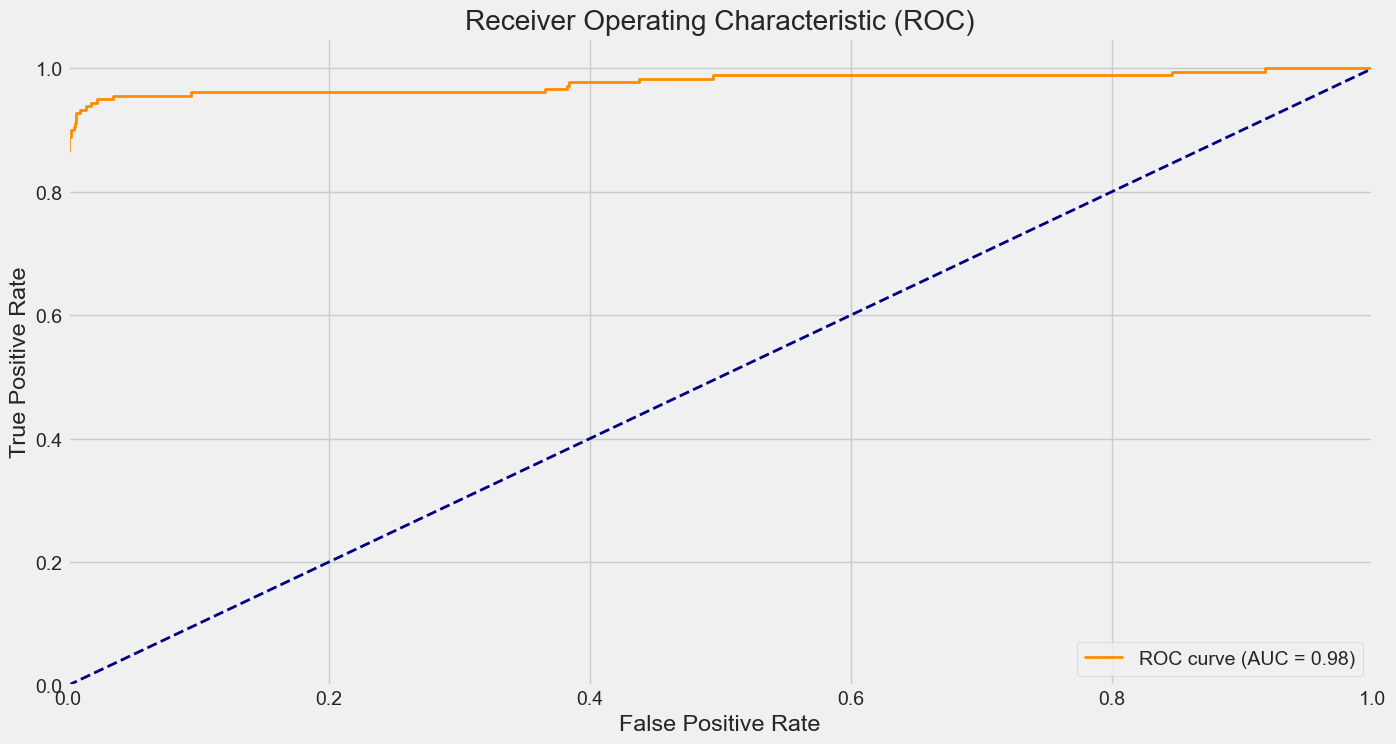

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
